In [2]:
import time
import numpy as np
import pandas as pd
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

from collections import Counter, defaultdict
import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [3]:
import sys
sys.path.append('../')
import utils

In [4]:
v_data, e_data, v_sets, e_sets, core_targets, ext_targets, core_testing = utils.load_for_jupyter()

LOADING DATA STARTED
Dataset already downloaded. Loading it from file system
LOADING DATA COMPLETED: 1.22 s
PREPROCESSING DATA STARTED
PREPROCESSING DATA COMPLETED: 393.41 s


In [5]:
# Sort based on testingFlag
data_splits = dict()

for i in v_sets:
    v_sets[i] = v_sets[i].sort_values('testingFlag')
    print(i,":")
    data_splits[i] = v_sets[i].testingFlag.value_counts().to_frame()
    print(v_sets[i].testingFlag.value_counts())
    v_sets[i] = v_sets[i].drop('testingFlag', axis=1)
    
# data_splits[i].iloc[INDEX].values[0]
# where INDEX:
# [0] testingFlag=NaN
# [1] testingFlag=0
# [2] testingFlag=1

Account :
-1.0    126601
 0.0     13787
 1.0      1488
Name: testingFlag, dtype: int64
Address :
-1.0    28354
 0.0     1568
 1.0       78
Name: testingFlag, dtype: int64
Customer :
-1.0    42040
 0.0    13662
 1.0      524
Name: testingFlag, dtype: int64
Derived Entity :
-1.0    26975
 0.0     3932
 1.0      367
Name: testingFlag, dtype: int64
External Entity :
-1.0    55043
 0.0     4757
 1.0      200
Name: testingFlag, dtype: int64


In [6]:
# keep track of the IDs for the testing cases later on

v_type = 'Account'

nan_tflag = data_splits[v_type].iloc[0].values[0]
train_tflag = data_splits[v_type].iloc[1].values[0]
test_tflag = data_splits[v_type].iloc[2].values[0]

train_cv_set = v_sets[v_type][nan_tflag:nan_tflag+train_tflag]
test_set = v_sets[v_type][-test_tflag:]


In [7]:
test_ids = test_set.index.values.tolist()

In [8]:
# Removing ExtendedCaseID:

for i in v_sets:
    v_sets[i] = v_sets[i].drop('ExtendedCaseGraphID', axis=1)

In [9]:
batch_size = 200
epochs = 10
num_samples = [8, 4]
dropout = 0.4
hinsage_layer_sizes = [32, 32]

In [10]:
G = sg.StellarDiGraph(v_sets, e_sets)

In [11]:
generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

def make_hinsage():
    return HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'relu'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

hinsage = make_hinsage()

In [12]:
def run_deep_graph_infomax(base_model, generator, epochs):
    t0 = time.time()
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train DGI
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    t1 = time.time()
    print(f'Time required: {t1-t0:.2f} s ({(t1-t0)/60:.1f} min)')
    
    return x_emb_in, x_emb_out, model

Epoch 1/10
710/710 [==============================] - 533s 750ms/step - loss: 0.2246
Epoch 2/10
710/710 [==============================] - 541s 762ms/step - loss: 0.0852
Epoch 3/10
710/710 [==============================] - 542s 763ms/step - loss: 0.0741
Epoch 4/10
710/710 [==============================] - 543s 764ms/step - loss: 0.0671
Epoch 5/10
710/710 [==============================] - 546s 769ms/step - loss: 0.0597
Epoch 6/10
710/710 [==============================] - 543s 765ms/step - loss: 0.0560
Epoch 7/10
710/710 [==============================] - 532s 750ms/step - loss: 0.0563
Epoch 8/10
710/710 [==============================] - 548s 772ms/step - loss: 0.0558
Epoch 9/10
710/710 [==============================] - 566s 797ms/step - loss: 0.0527
Epoch 10/10
710/710 [==============================] - 562s 791ms/step - loss: 0.0517
Time required: 5468.39 s (91.1 min)


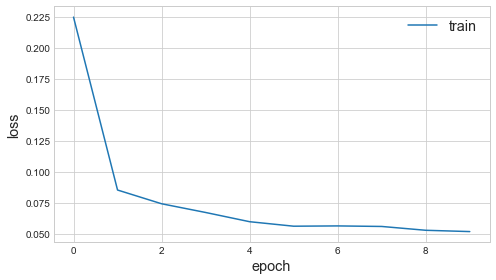

In [13]:
# Run Deep Graph Infomax

x_emb_in, x_emb_out, model = run_deep_graph_infomax(hinsage, generator, epochs=epochs)

In [14]:
# SPLIT

train_cv_set = v_sets['Account'][126863:126863+13769]

In [15]:
train_cv_set

,Revenue Size Flag,source_degree,target_degree,CoreCaseGraphID_0.0,CoreCaseGraphID_1.0,CoreCaseGraphID_2.0,CoreCaseGraphID_3.0,CoreCaseGraphID_4.0,CoreCaseGraphID_5.0,CoreCaseGraphID_6.0,...,CoreCaseGraphID_3990.0,CoreCaseGraphID_3991.0,CoreCaseGraphID_3992.0,CoreCaseGraphID_3993.0,CoreCaseGraphID_3995.0,CoreCaseGraphID_3996.0,CoreCaseGraphID_3997.0,CoreCaseGraphID_3998.0,CoreCaseGraphID_3999.0,CoreCaseGraphID_4000.0
node_id,,,,,,,,,,,,,,,,,,,,,
1502006651,0.1,6.0,8.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15020065070,0.8,6.0,7.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15020033391,1.0,3.0,12.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1502005938,0.3,4.0,5.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1502006615,1.0,6.0,6.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15020046126,0.1,5.0,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1502008770,0.3,5.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15020113197,0.8,0.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
train_cv_embs = emb_model.predict(
    generator.flow(train_cv_set.index.values)
)
train_cv_embs_2d = pd.DataFrame(
    TSNE(n_components=2).fit_transform(train_cv_embs), 
    index=train_cv_set.index.values
)

In [17]:
# Coloring based on ExtendedCaseGraphID

# these are the training+cv indexes
node_ids = train_cv_set.index.values.tolist()

# these are the training+cv Extended case ID
ext_targets_2 = v_data.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID 

label_map = {l: i*10 for i, l in enumerate(np.unique(ext_targets_2), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets_2]

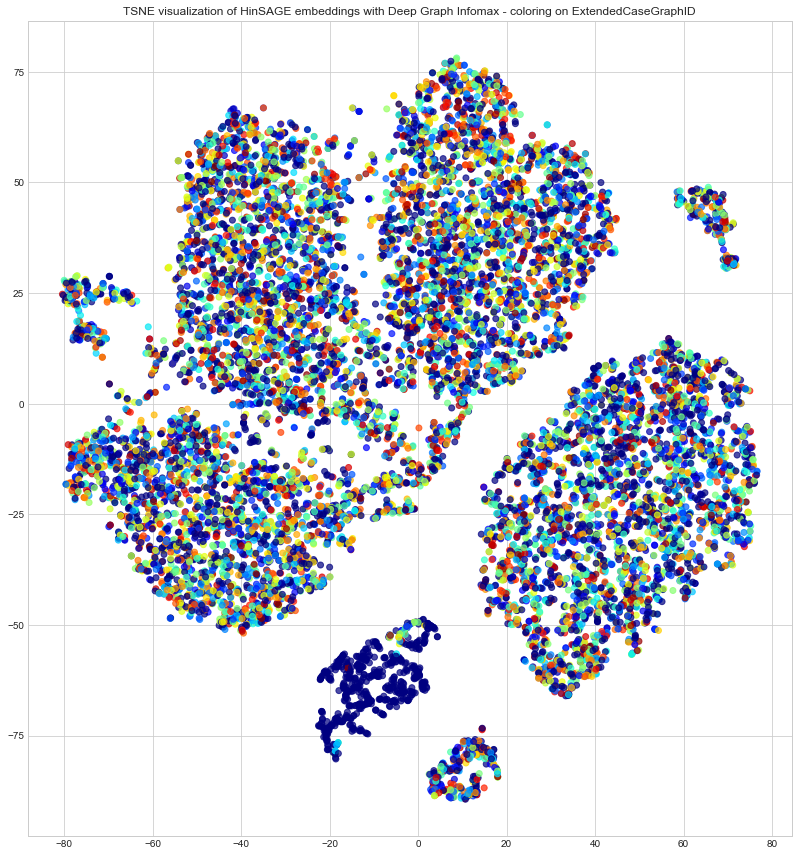

In [18]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    train_cv_embs_2d[0],
    train_cv_embs_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax - coloring on ExtendedCaseGraphID")
plt.show()

In [19]:
# account core case ID based coloring

# these are the training+cv core case IDs
ext_targets_5 = v_data.loc[[int(node_id) for node_id in node_ids]]['CoreCaseGraphID']

label_map = {l: i*100 for i, l in enumerate(np.unique(ext_targets_5), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets_5]

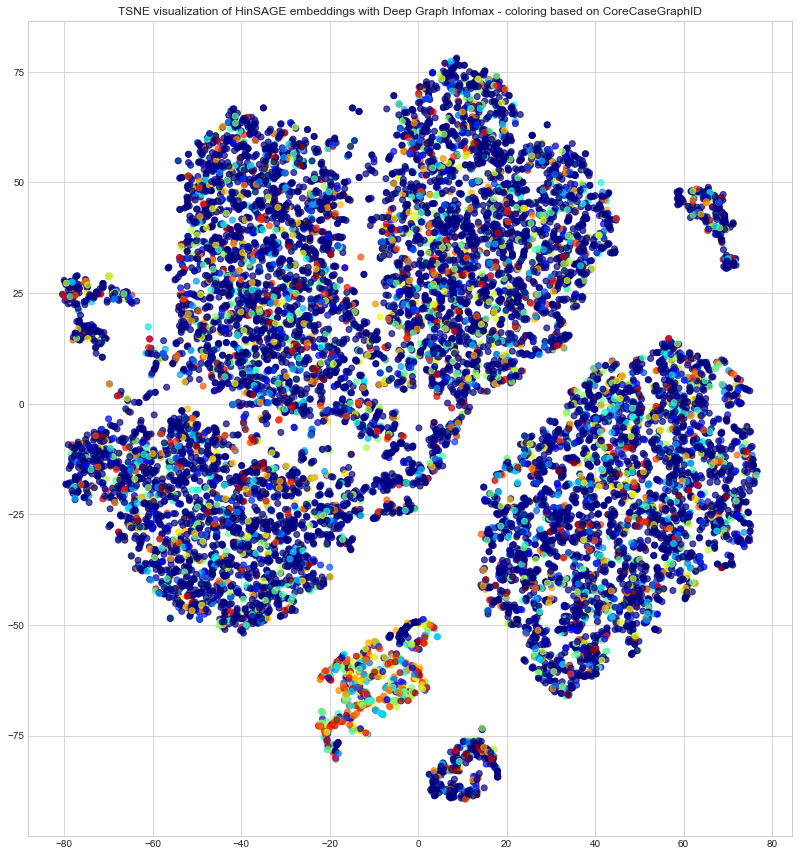

In [20]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    train_cv_embs_2d[0],
    train_cv_embs_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax - coloring based on CoreCaseGraphID")
plt.show()

In [21]:
# determine split size based on train_cv size, do something like 80% 20%
n_embs = train_cv_embs.shape[0]
train_size = int(n_embs*0.85)
cv_size = int(n_embs*0.15)

In [22]:
# very rudimentary and shitty splitting:

train_set = train_cv_embs[:train_size]
train_labels = np.ravel(pd.DataFrame(ext_targets_2.values[:train_size]).fillna(0))

cv_set = train_cv_embs[-cv_size:]
cv_labels = np.ravel(pd.DataFrame(ext_targets_2.values[-cv_size:]).fillna(0))

# create test set for production

In [23]:
###### CLASSIFY

In [45]:
# Experiment different classifiers:
classifiers = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    #'svm2': SVC(kernel='rbf'),
    #'svm3': SVC(kernel='sigmoid'),
    #'mlp1': MLPClassifier(max_iter=500),
    #'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100], max_iter=500),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    #'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression(multi_class="auto", solver="lbfgs", max_iter=500)
}

f1_scores = dict()
accs = dict()
def test_classifiers():
    for clf_name in classifiers:
        t0 = time.time()
        clf = classifiers[clf_name]
        clf.fit(train_set, train_labels)
        cv_pred = clf.predict(cv_set)
        clf_f1 = f1_score(cv_labels, cv_pred, average='macro')
        clf_acc = (cv_pred == cv_labels).mean()
        f1_scores[clf_name] = clf_f1
        accs[clf_name] = clf_acc
        t1 = time.time()
        print(f"Classifier: {clf_name} - f1: {clf_f1:.6f} - acc: {clf_acc:.6f} - time: {t1-t0:.0f} s")
        
test_classifiers()

Classifier: mnb - f1: 0.000533 - acc: 0.331719 - time: 0 s
Classifier: gnb - f1: 0.000000 - acc: 0.000000 - time: 1 s
Classifier: svm1 - f1: 0.000533 - acc: 0.331719 - time: 212 s
Classifier: ada - f1: 0.000533 - acc: 0.331719 - time: 53 s
Classifier: dtc - f1: 0.000898 - acc: 0.108475 - time: 12 s
Classifier: rfc - f1: 0.000513 - acc: 0.322034 - time: 141 s
Classifier: lr - f1: 0.000533 - acc: 0.331719 - time: 122 s


In [25]:
classifier = DecisionTreeClassifier()

In [26]:
classifier.fit(
    X=train_set,
    y=train_labels,
)

DecisionTreeClassifier()

In [43]:
cv_pred = classifier.predict(cv_set)

# TODO
#cv_pred = target_encoding.inverse_transform(cv_pred)


f1_avg = f1_score(cv_labels, cv_pred, average='macro')
acc = (cv_pred == cv_labels).mean()

print(f"f1: {f1_avg:.6f} - acc: {acc:.6f}")

f1: 0.000481 - acc: 0.109443


In [28]:
pd.DataFrame(cv_pred).value_counts().to_frame()

,0
0,
0.0,580
2719.0,8
325.0,7
1140.0,7
421.0,7
...,...
3679.0,1
1568.0,1
1549.0,1


In [29]:
pd.DataFrame(cv_labels).value_counts().to_frame()

,0
0,
0.0,685
1027.0,7
3500.0,6
2400.0,6
1599.0,5
...,...
2288.0,1
2280.0,1
2277.0,1


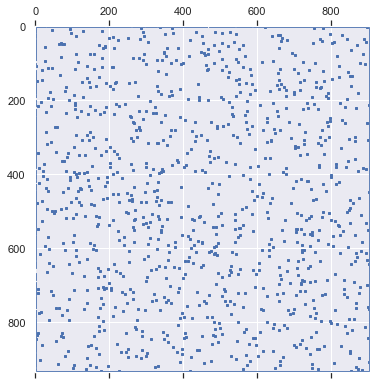

In [30]:
confusion_matrix = pd.crosstab(
    cv_labels,
    cv_pred,
    rownames=['True'],
    colnames=['Predicted'],
    margins=True
)
sns.set(rc={'figure.figsize':(6, 10)})
plt.spy(confusion_matrix, precision = 0.1, markersize = 2)

In [31]:
### EXPERIMENTS

In [32]:
# What if I used the classifier on the fraudolent nodes directly?

In [33]:
train_set_fraud = []
train_labels_fraud = []
cv_set_fraud = []
cv_labels_fraud = []

for l in range(len(train_labels)):
    if int(train_labels[l]) != 0:
        train_set_fraud.append(train_set[l])
        train_labels_fraud.append(train_labels[l])
    
for l in range(len(cv_labels)):
    if int(cv_labels[l]) != 0:
        cv_set_fraud.append(cv_set[l])
        cv_labels_fraud.append(cv_labels[l])
        
clf = RandomForestClassifier()
clf.fit(train_set_fraud, train_labels_fraud)
cv_pred_fraud = clf.predict(cv_set_fraud)
f1_avg_fraud = f1_score(cv_labels_fraud, cv_pred_fraud, average='macro')
acc_fraud = (cv_pred_fraud == cv_labels_fraud).mean()
print(f"f1: {f1_avg_fraud:.6f} - acc: {acc_fraud:.6f}")

f1: 0.001238 - acc: 0.002174


In [34]:
# What metrics would I get if I assumed all CoreCaseID to be equal to ExtendedCaseID?

In [35]:
train_cv_set

,Revenue Size Flag,source_degree,target_degree,CoreCaseGraphID_0.0,CoreCaseGraphID_1.0,CoreCaseGraphID_2.0,CoreCaseGraphID_3.0,CoreCaseGraphID_4.0,CoreCaseGraphID_5.0,CoreCaseGraphID_6.0,...,CoreCaseGraphID_3990.0,CoreCaseGraphID_3991.0,CoreCaseGraphID_3992.0,CoreCaseGraphID_3993.0,CoreCaseGraphID_3995.0,CoreCaseGraphID_3996.0,CoreCaseGraphID_3997.0,CoreCaseGraphID_3998.0,CoreCaseGraphID_3999.0,CoreCaseGraphID_4000.0
node_id,,,,,,,,,,,,,,,,,,,,,
1502006651,0.1,6.0,8.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15020065070,0.8,6.0,7.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15020033391,1.0,3.0,12.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1502005938,0.3,4.0,5.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1502006615,1.0,6.0,6.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15020046126,0.1,5.0,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1502008770,0.3,5.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15020113197,0.8,0.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
acc_core_data = v_data.loc[v_data.Label == 'Account']
acc_core_data['CoreCaseGraphID'] = acc_core_data['CoreCaseGraphID'].fillna(0)
acc_core_data['ExtendedCaseGraphID'] = acc_core_data['ExtendedCaseGraphID'].fillna(0)
acc_core_data['testingFlag'] = acc_core_data['testingFlag'].fillna(-1)

In [37]:
train_data = acc_core_data.loc[acc_core_data['testingFlag'] == 0]

In [38]:
trainpreds = []
for ind, row in train_data.iterrows():
    if int(row.CoreCaseGraphID) != 0:
        trainpreds.append(row.CoreCaseGraphID)
    else:
        trainpreds.append(0.0)